In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# 한글 폰트 설정
plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

In [2]:
# 파일 읽기
gaepo_df = pd.read_csv("개포로_통행속도_기상.csv", encoding='cp949')

# 결측치 확인
print('개포로 결측치 수 : ',gaepo_df['속도'].isna().sum())

개포로 결측치 수 :  825


/var/folders/0t/0jprd7f95qsb1p_xmw35n4l80000gn/T/ipykernel_37848/1718086446.py:2: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  gaepo_df = pd.read_csv("개포로_통행속도_기상.csv", encoding='cp949')


In [3]:
def fill_missing_values(df):
    # 일시 컬럼을 datetime 형식으로 변환
    df['일시'] = pd.to_datetime(df['일시'])
    
    # 시간 추출
    df['hour'] = df['일시'].dt.hour
    
    # 각 결측치에 대해
    null_indices = df[df['속도'].isnull()].index
    
    for idx in null_indices:
        current_row = df.loc[idx]
        
        # 현재 결측치의 조건과 동일한 데이터 필터링
        same_conditions = (
            (df['링크아이디'] == current_row['링크아이디']) & 
            (df['hour'] == current_row['hour']) & 
            (df['isHoliday'] == current_row['isHoliday']) &
            (df['속도'].notnull())  # 결측치가 아닌 데이터만
        )
        
        # 조건에 맞는 평균 속도 계산
        mean_speed = df[same_conditions]['속도'].mean()
        
        # 만약 조건에 맞는 데이터가 없다면 (mean_speed가 NaN이라면)
        # 휴일 조건을 제외하고 다시 계산
        if pd.isna(mean_speed):
            same_conditions = (
                (df['링크아이디'] == current_row['링크아이디']) & 
                (df['hour'] == current_row['hour']) &
                (df['속도'].notnull())
            )
            mean_speed = df[same_conditions]['속도'].mean()
        
        # 여전히 평균을 구할 수 없다면 전체 링크아이디의 해당 시간대 평균 사용
        if pd.isna(mean_speed):
            same_conditions = (
                (df['hour'] == current_row['hour']) &
                (df['속도'].notnull())
            )
            mean_speed = df[same_conditions]['속도'].mean()
        
        # 결측치 채우기
        df.loc[idx, '속도'] = mean_speed
        
    return df

# 사용
gaepo_df = fill_missing_values(gaepo_df.copy())


print('개포로 결측치 수 : ',gaepo_df['속도'].isna().sum())

개포로 결측치 수 :  0


In [4]:
gaepo_df.drop(columns = ['일자', '요일', '도로명', '시점명', '종점명', '방향', '기능유형구분', '도심/외곽구분', '시간','지점', '지점명', 'dateName', 'seq', 'dateKind'], inplace = True)

In [5]:
# 속도가 비어있는 행의 인덱스 출력
print("속도가 비어있는 행의 인덱스:")
print(gaepo_df[gaepo_df['속도'].isna()].index)

속도가 비어있는 행의 인덱스:
Index([], dtype='int64')


In [7]:
def train_lstm_model(df, name, target_col, time_steps=24, train_ratio=0.8, epochs=50, batch_size=32):
    """
    LSTM 모델을 학습하고 예측하는 함수
    
    Parameters:
    -----------
    df : DataFrame
        입력 데이터프레임
    target_col : str 
        예측하고자 하는 타겟 컬럼명
    time_steps : int
        시계열 데이터의 시간 스텝 (기본값: 24)
    train_ratio : float
        학습 데이터 비율 (기본값: 0.8)
    epochs : int
        학습 에포크 수 (기본값: 50)
    batch_size : int
        배치 크기 (기본값: 32)
    """
    
    unique_links = df['링크아이디'].unique()
    results = {}
    predictions_df = pd.DataFrame()
    
    for link_id in unique_links:
        print(f"\n링크아이디 {link_id}에 대한 분석")
        
        # 해당 링크의 데이터만 추출
        link_df = df[df['링크아이디'] == link_id]
        
        # 데이터 전처리
        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(link_df[target_col].values.reshape(-1,1))

        # 시계열 데이터셋 생성
        def create_dataset(data, time_steps=1):
            X, y = [], []
            for i in range(len(data) - time_steps):
                X.append(data[i:(i + time_steps), 0])
                y.append(data[i + time_steps, 0])
            return np.array(X), np.array(y)

        # 시계열 데이터 생성
        X, y = create_dataset(scaled_data, time_steps)

        # 학습/테스트 데이터 분할
        train_size = int(len(X) * train_ratio)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # 데이터 reshape (LSTM 입력 형태로)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

        # LSTM 모델 구성
        model = Sequential([
            LSTM(50, activation='relu', input_shape=(time_steps, 1), return_sequences=True),
            LSTM(50, activation='relu'),
            Dense(1)
        ])

        # 모델 컴파일
        model.compile(optimizer='adam', loss='mse')

        # 모델 학습
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                          validation_split=0.1, verbose=0)

        # 예측
        train_predict = model.predict(X_train)
        test_predict = model.predict(X_test)

        # 예측값 역변환
        train_predict = scaler.inverse_transform(train_predict)
        y_train_inv = scaler.inverse_transform([y_train])
        test_predict = scaler.inverse_transform(test_predict)
        y_test_inv = scaler.inverse_transform([y_test])
        
        # 24시간 미래 예측
        last_sequence = scaled_data[-time_steps:]
        future_predictions = []
        
        current_sequence = last_sequence.reshape((1, time_steps, 1))
        for _ in range(24):  # 24시간 예측
            next_pred = model.predict(current_sequence)
            future_predictions.append(next_pred[0,0])
            current_sequence = np.roll(current_sequence, -1)
            current_sequence[0,-1,0] = next_pred[0,0]
            
        future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1,1))
        
        # 예측 결과를 DataFrame에 추가
        temp_df = pd.DataFrame({
            '링크아이디': [link_id] * 24,
            'hour': range(24),
            '예측속도': future_predictions.flatten()
        })
        predictions_df = pd.concat([predictions_df, temp_df])

        # 결과 시각화
        plt.figure(figsize=(15,6))
        plt.plot(y_test_inv.T, label='실제값')
        plt.plot(test_predict, label='예측값')
        plt.title(f'{name} 링크 {link_id} {target_col} 예측 결과')
        plt.xlabel('시간')
        plt.ylabel(target_col)
        plt.legend()
        plt.show()

        # 모델 평가 결과 저장
        results[link_id] = {
            'model': model,
            'scaler': scaler,
            'metrics': {
                'Train RMSE': np.sqrt(mean_squared_error(y_train_inv.T, train_predict)),
                'Test RMSE': np.sqrt(mean_squared_error(y_test_inv.T, test_predict)),
                'Train MAE': mean_absolute_error(y_train_inv.T, train_predict),
                'Test MAE': mean_absolute_error(y_test_inv.T, test_predict),
                'Train R2': r2_score(y_train_inv.T, train_predict),
                'Test R2': r2_score(y_test_inv.T, test_predict),
                'Train Adjusted R2': 1 - (1-r2_score(y_train_inv.T, train_predict))*(len(y_train_inv.T)-1)/(len(y_train_inv.T)-X_train.shape[2]-1),
                'Test Adjusted R2': 1 - (1-r2_score(y_test_inv.T, test_predict))*(len(y_test_inv.T)-1)/(len(y_test_inv.T)-X_test.shape[2]-1)
            }
        }
        
        # 평가 결과 출력
        print(f'{name}의 링크 {link_id} 평가 결과:')
        for metric, value in results[link_id]['metrics'].items():
            print(f'{metric}: {value}')
        print('-' * 50)
    
    # 예측 결과를 CSV 파일로 저장
    predictions_df.to_csv(f'{name}_predictions.csv', index=False)
    return results, predictions_df

### 모델 학습


링크아이디 1220008200에 대한 분석


2025-02-15 18:41:59.350986: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 12ms/step


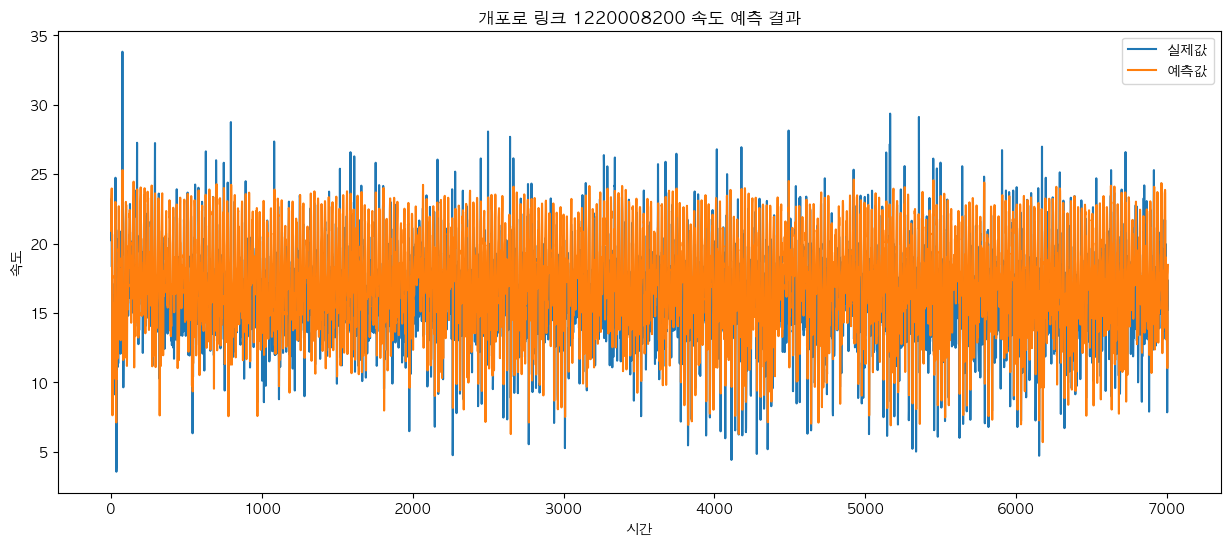

개포로의 링크 1220008200 평가 결과:
Train RMSE: 2.8863452760603
Test RMSE: 3.139213799091568
Train MAE: 2.1809638903460478
Test MAE: 2.402376956484651
Train R2: 0.7655941510038989
Test R2: -0.11494767915059234
Train Adjusted R2: 0.7655857883264463
Test Adjusted R2: -0.11510682098318603
--------------------------------------------------

링크아이디 1220020500에 대한 분석
1/1 [==============================] - 0s 12ms/step


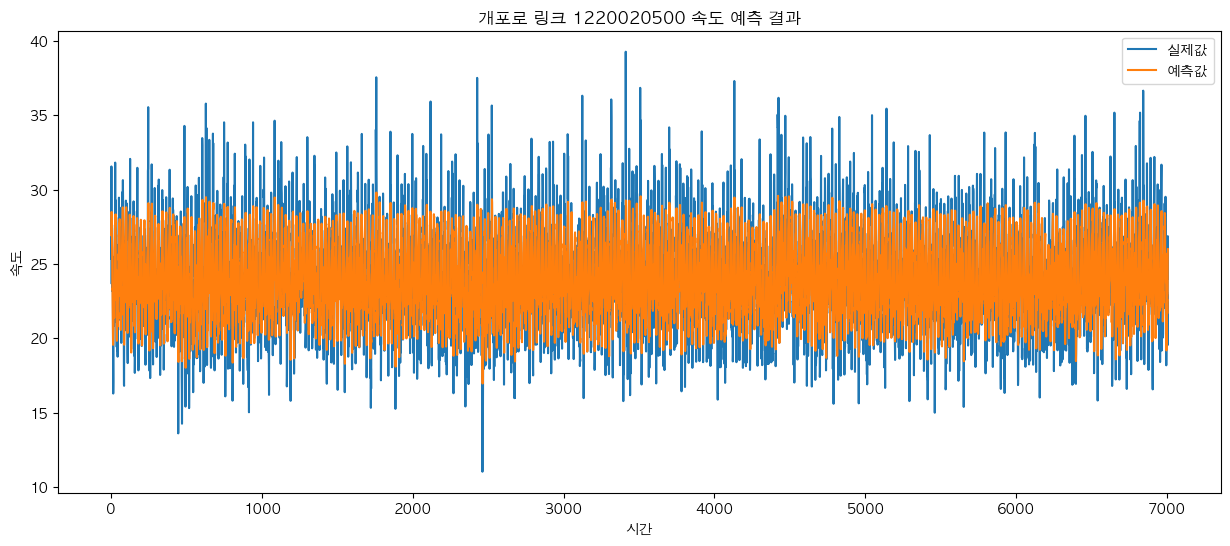

개포로의 링크 1220020500 평가 결과:
Train RMSE: 2.405094286243958
Test RMSE: 2.3803155074003577
Train MAE: 1.8406091182351192
Test MAE: 1.8285172968049632
Train R2: 0.6259375204217288
Test R2: 0.4937913406740234
Train Adjusted R2: 0.6259241753457538
Test Adjusted R2: 0.493719087082912
--------------------------------------------------

링크아이디 1220020400에 대한 분석
1/1 [==============================] - 0s 10ms/step


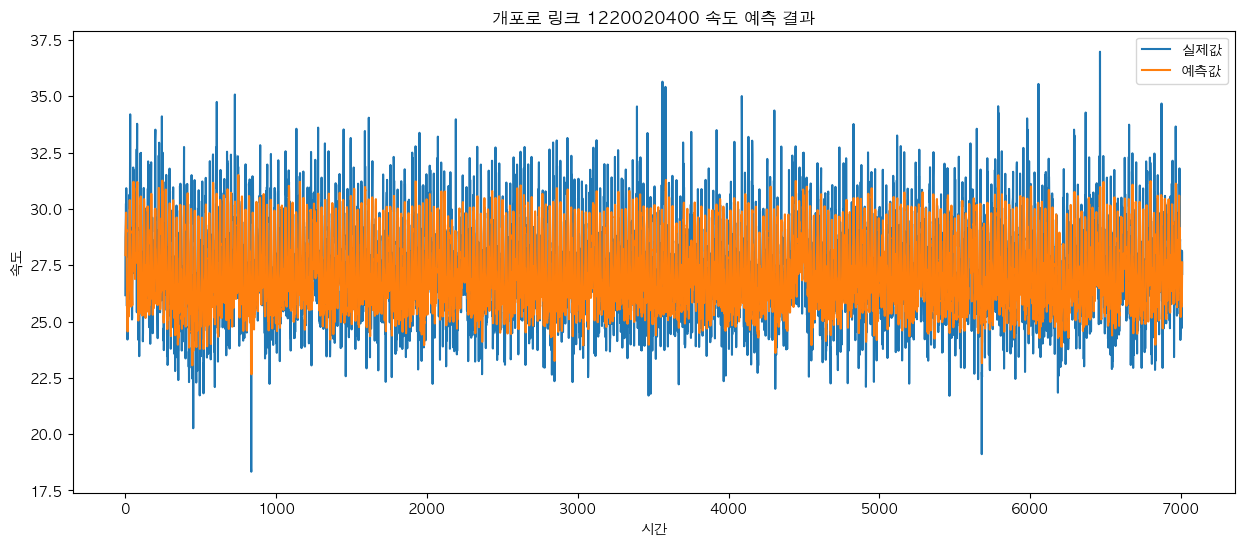

개포로의 링크 1220020400 평가 결과:
Train RMSE: 1.7125965872946978
Test RMSE: 1.4800004873518267
Train MAE: 1.2960951244304886
Test MAE: 1.1329425850049528
Train R2: 0.5400496473436758
Test R2: 0.5226043178916593
Train Adjusted R2: 0.5400332381266706
Test Adjusted R2: 0.5225361769150523
--------------------------------------------------

링크아이디 1220018700에 대한 분석
1/1 [==============================] - 0s 12ms/step


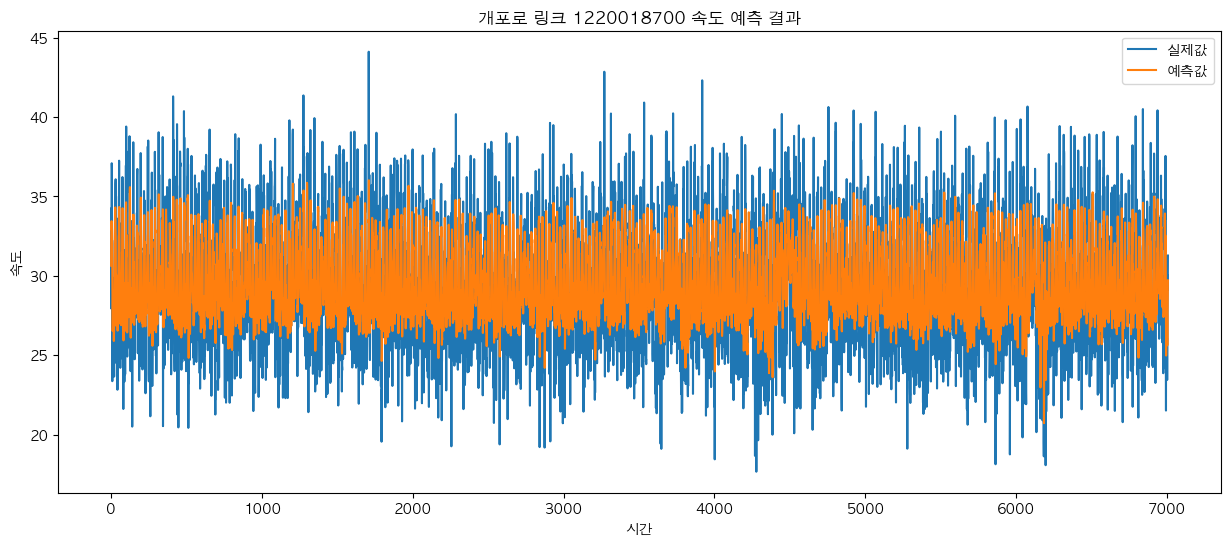

개포로의 링크 1220018700 평가 결과:
Train RMSE: 3.1060384222488353
Test RMSE: 2.9311935145155754
Train MAE: 2.3976413758985258
Test MAE: 2.25185213412074
Train R2: 0.4116177855154062
Test R2: 0.37204569692347833
Train Adjusted R2: 0.4115967943554174
Test Adjusted R2: 0.3719560659924084
--------------------------------------------------

링크아이디 1220017300에 대한 분석
1/1 [==============================] - 0s 12ms/step


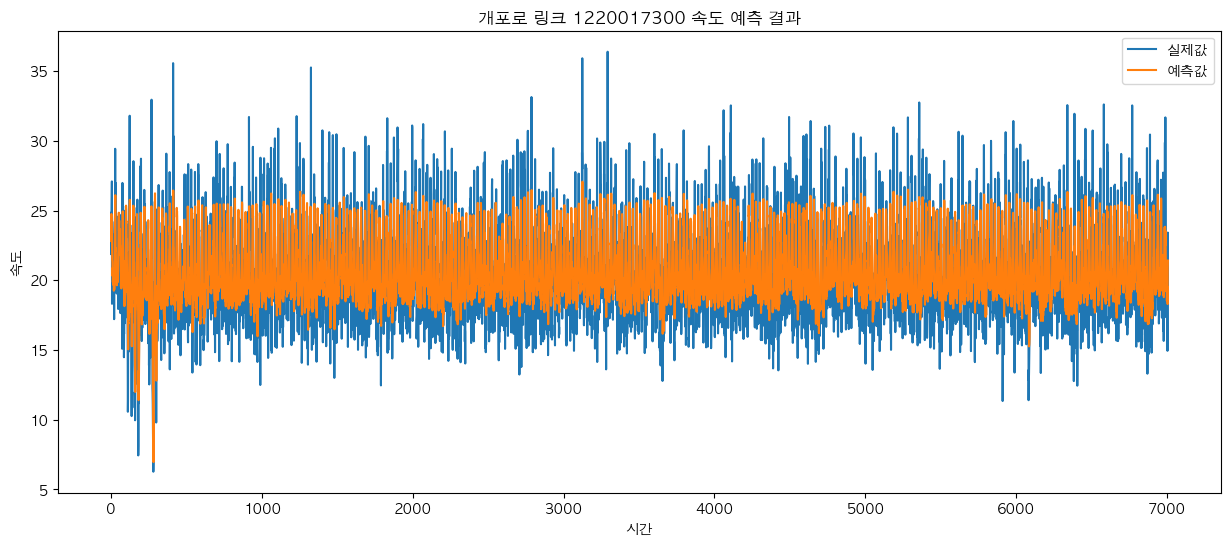

개포로의 링크 1220017300 평가 결과:
Train RMSE: 2.752732862653668
Test RMSE: 2.7503789041412454
Train MAE: 2.088993916225259
Test MAE: 2.1047232782463707
Train R2: 0.40524255586464164
Test R2: 0.299665097239892
Train Adjusted R2: 0.4052213372615686
Test Adjusted R2: 0.29956513507849314
--------------------------------------------------

링크아이디 1220015700에 대한 분석
1/1 [==============================] - 0s 12ms/step


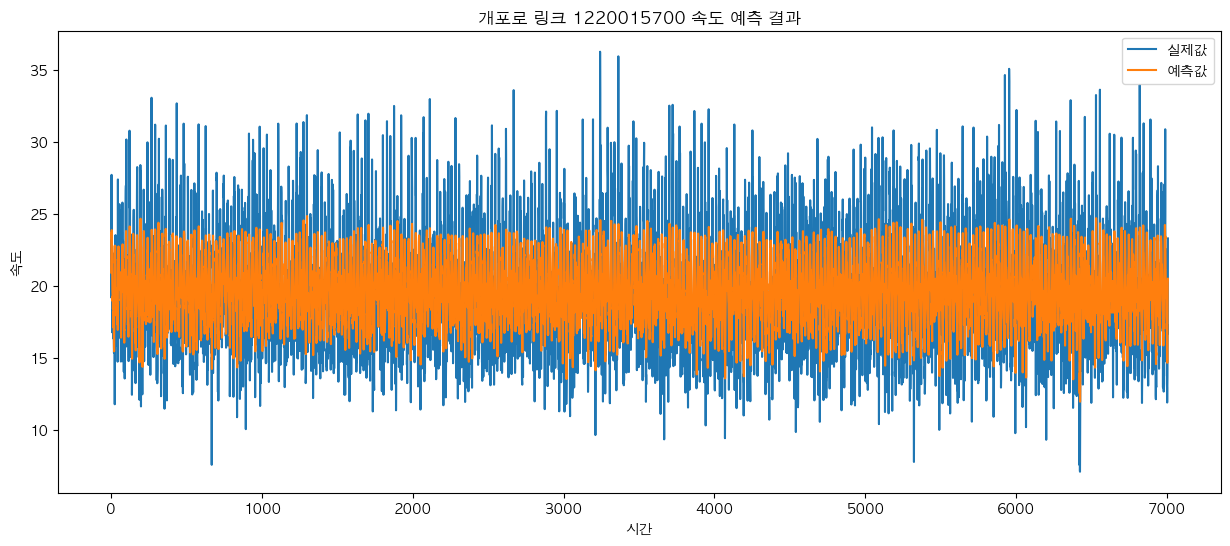

개포로의 링크 1220015700 평가 결과:
Train RMSE: 3.3088186362070724
Test RMSE: 3.2387591721624474
Train MAE: 2.5719290563039476
Test MAE: 2.5368703097767167
Train R2: 0.35455392462352553
Test R2: 0.3306294251817471
Train Adjusted R2: 0.3545308976497339
Test Adjusted R2: 0.3305338827074653
--------------------------------------------------

링크아이디 1220012100에 대한 분석
1/1 [==============================] - 0s 11ms/step


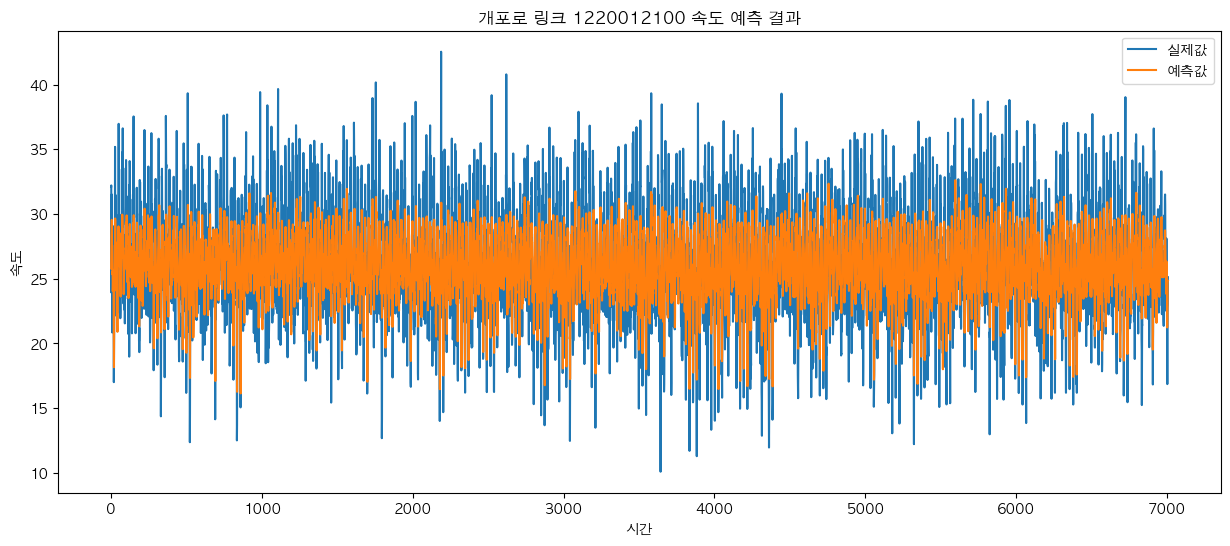

개포로의 링크 1220012100 평가 결과:
Train RMSE: 2.816691827842817
Test RMSE: 2.897566153672116
Train MAE: 2.159753789812089
Test MAE: 2.24627876320653
Train R2: 0.3339044289159787
Test R2: 0.5099908678833596
Train Adjusted R2: 0.3338806652495111
Test Adjusted R2: 0.5099209265285043
--------------------------------------------------

링크아이디 1220008300에 대한 분석
1/1 [==============================] - 0s 10ms/step


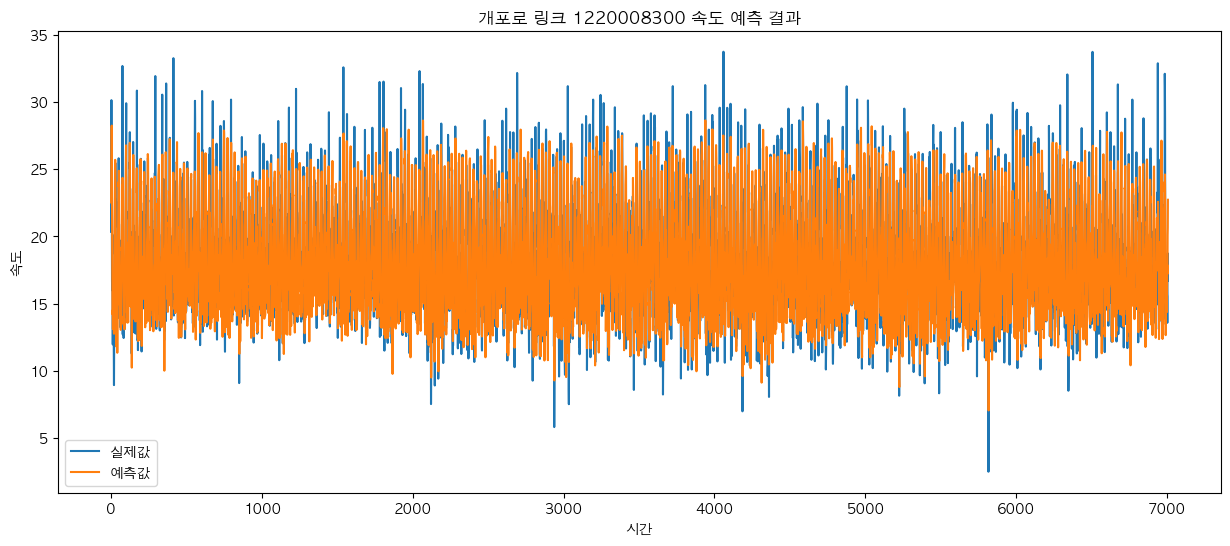

개포로의 링크 1220008300 평가 결과:
Train RMSE: 3.150451016368174
Test RMSE: 3.171957156526736
Train MAE: 2.4033743389976725
Test MAE: 2.4144493412965575
Train R2: 0.7700567612767792
Test R2: 0.3161087109560332
Train Adjusted R2: 0.7700485578076846
Test Adjusted R2: 0.3160110958705288
--------------------------------------------------

링크아이디 1220013700에 대한 분석
1/1 [==============================] - 0s 10ms/step


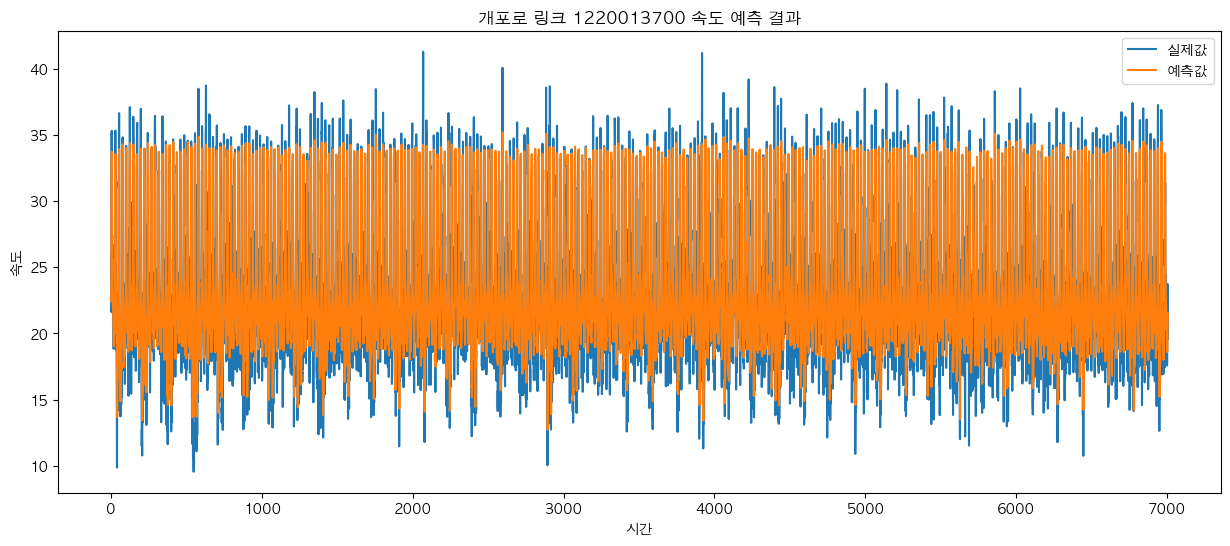

개포로의 링크 1220013700 평가 결과:
Train RMSE: 2.8144505675798768
Test RMSE: 2.8200173579039713
Train MAE: 2.164465751991984
Test MAE: 2.1390901055851606
Train R2: 0.7578694855281647
Test R2: 0.7400712751492071
Train Adjusted R2: 0.7578608472650725
Test Adjusted R2: 0.7400341742749778
--------------------------------------------------

링크아이디 1220012000에 대한 분석
1/1 [==============================] - 0s 10ms/step


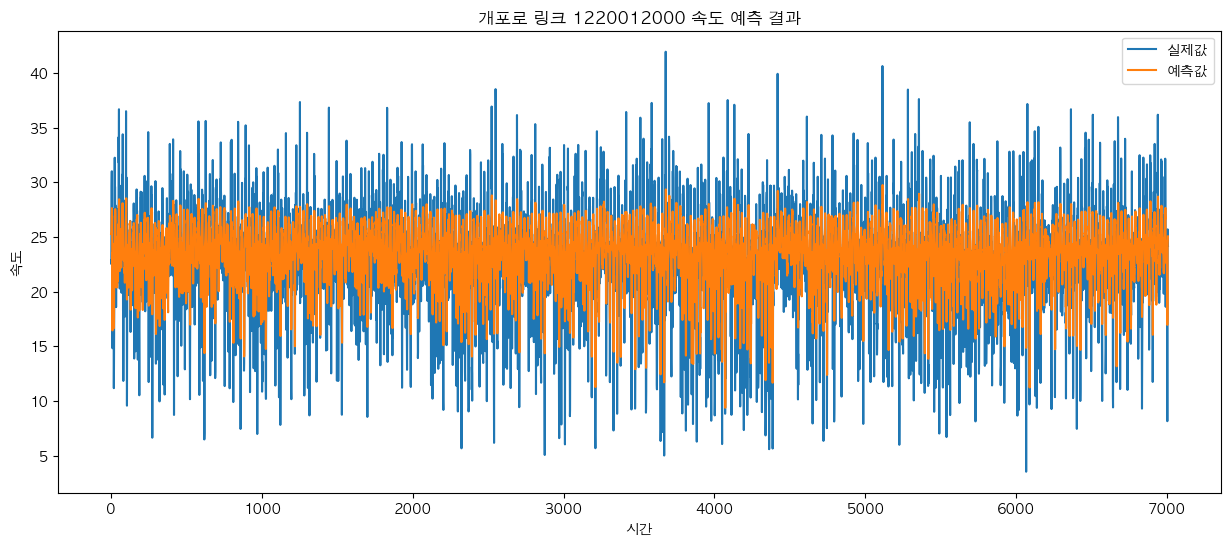

개포로의 링크 1220012000 평가 결과:
Train RMSE: 2.8759446388183347
Test RMSE: 3.496832670559102
Train MAE: 2.1677842629716175
Test MAE: 2.634267937473698
Train R2: 0.3155002754811306
Test R2: 0.38625968548004064
Train Adjusted R2: 0.31547585522695587
Test Adjusted R2: 0.3861720833797666
--------------------------------------------------

링크아이디 1220013600에 대한 분석
1/1 [==============================] - 0s 10ms/step


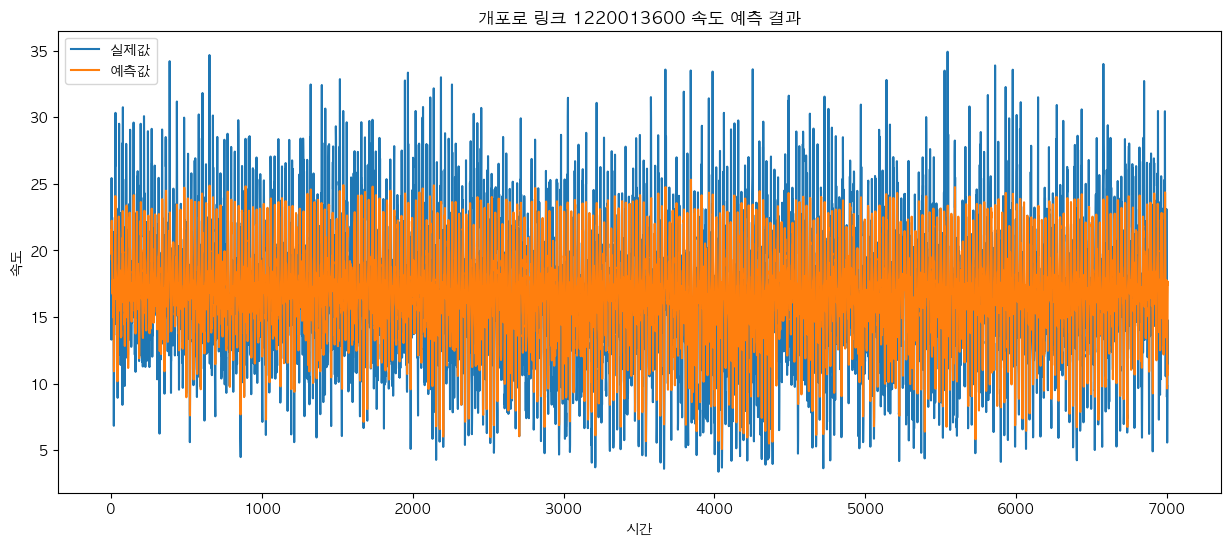

개포로의 링크 1220013600 평가 결과:
Train RMSE: 3.6624640129218213
Test RMSE: 3.6656977281220136
Train MAE: 2.8292934608679663
Test MAE: 2.8899056309324176
Train R2: 0.43585334301208367
Test R2: 0.5040122554590576
Train Adjusted R2: 0.43583321648133133
Test Adjusted R2: 0.5039414607481612
--------------------------------------------------

링크아이디 1220015600에 대한 분석
1/1 [==============================] - 0s 10ms/step


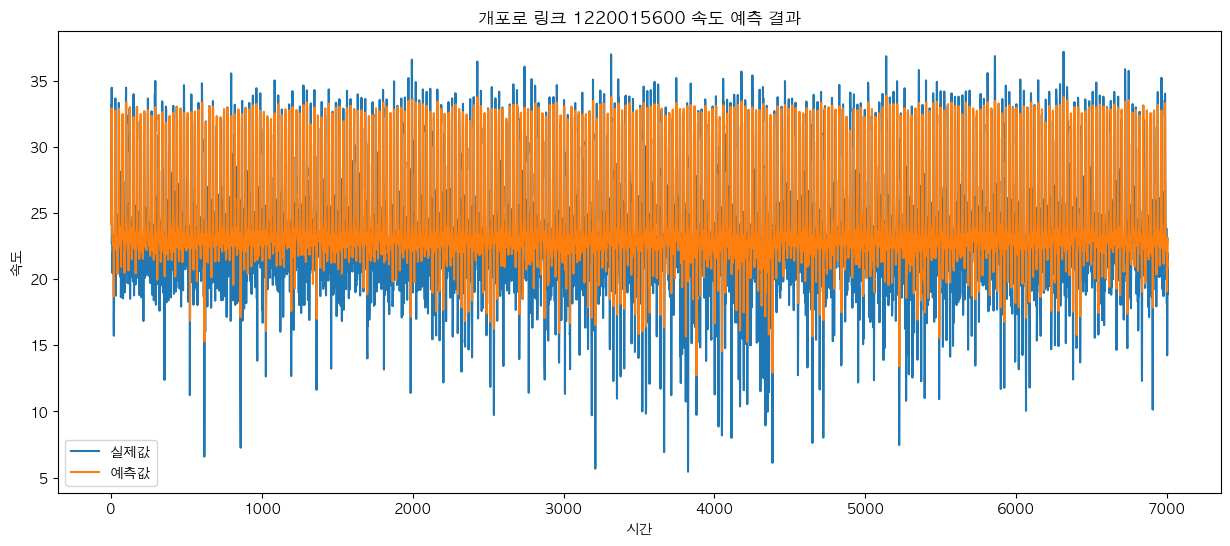

개포로의 링크 1220015600 평가 결과:
Train RMSE: 2.3741647559031547
Test RMSE: 2.6316115817553336
Train MAE: 1.7951172983281392
Test MAE: 1.9625940055011317
Train R2: 0.6718336831008207
Test R2: 0.6755685884781144
Train Adjusted R2: 0.6718219754191618
Test Adjusted R2: 0.6755222808258846
--------------------------------------------------

링크아이디 1220017200에 대한 분석
1/1 [==============================] - 0s 12ms/step


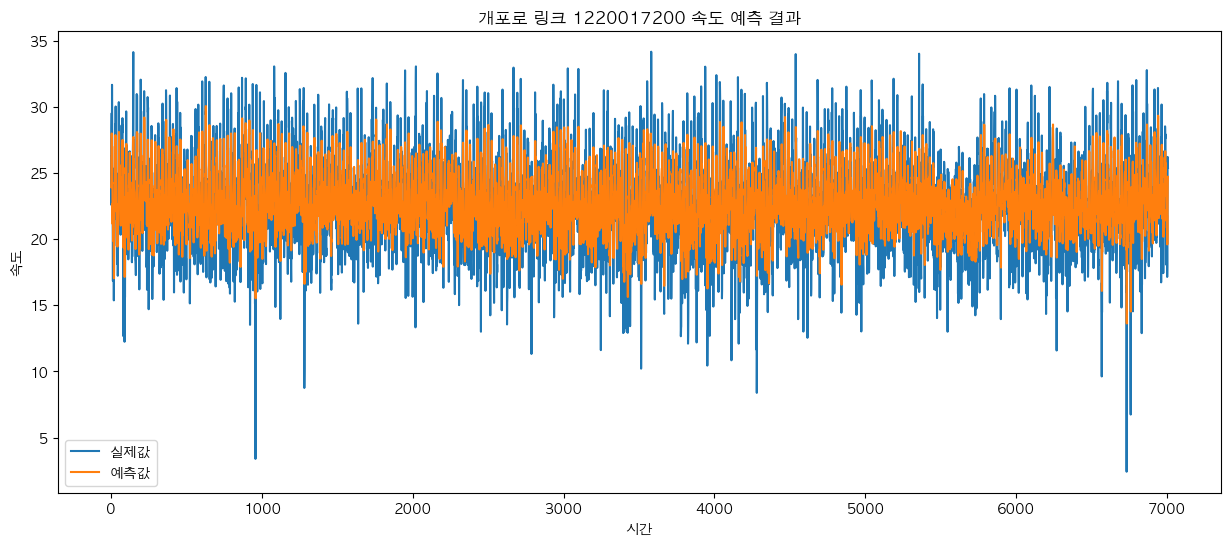

개포로의 링크 1220017200 평가 결과:
Train RMSE: 2.7812437137799977
Test RMSE: 2.7941600870971586
Train MAE: 2.1004101169035945
Test MAE: 2.0928791985275925
Train R2: 0.5989267690498155
Test R2: 0.30053798311134394
Train Adjusted R2: 0.5989124603366172
Test Adjusted R2: 0.30043814554113424
--------------------------------------------------

링크아이디 1220018600에 대한 분석
1/1 [==============================] - 0s 10ms/step


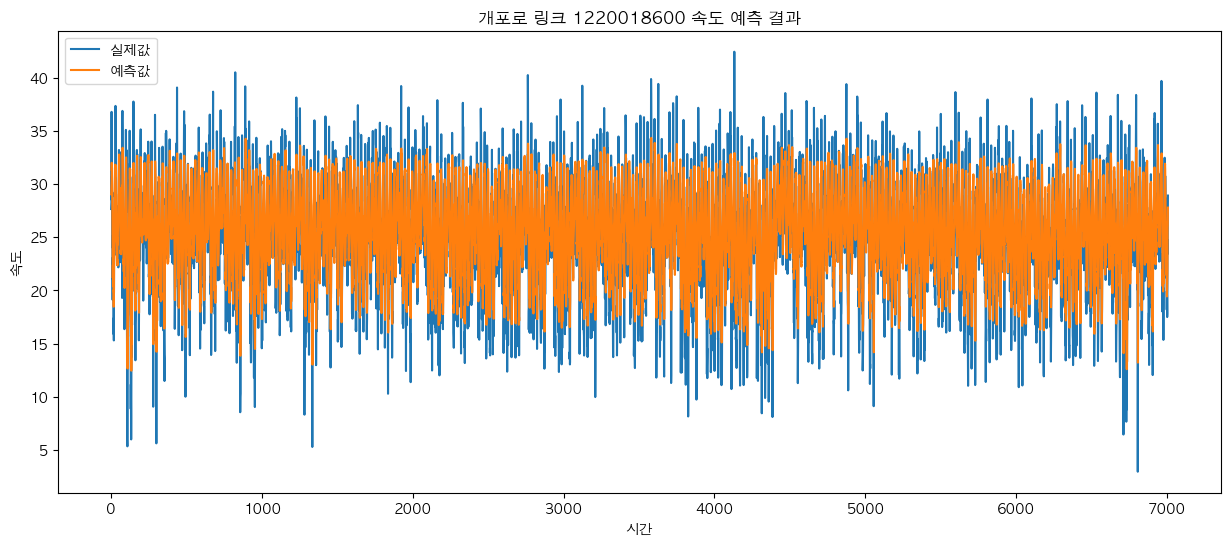

개포로의 링크 1220018600 평가 결과:
Train RMSE: 2.714846021213726
Test RMSE: 3.1747817184569467
Train MAE: 2.0101985959764246
Test MAE: 2.4074913690208115
Train R2: 0.6767284693919404
Test R2: 0.6443917151032845
Train Adjusted R2: 0.6767169363369776
Test Adjusted R2: 0.6443409574263081
--------------------------------------------------

링크아이디 1220007000에 대한 분석
1/1 [==============================] - 0s 10ms/step


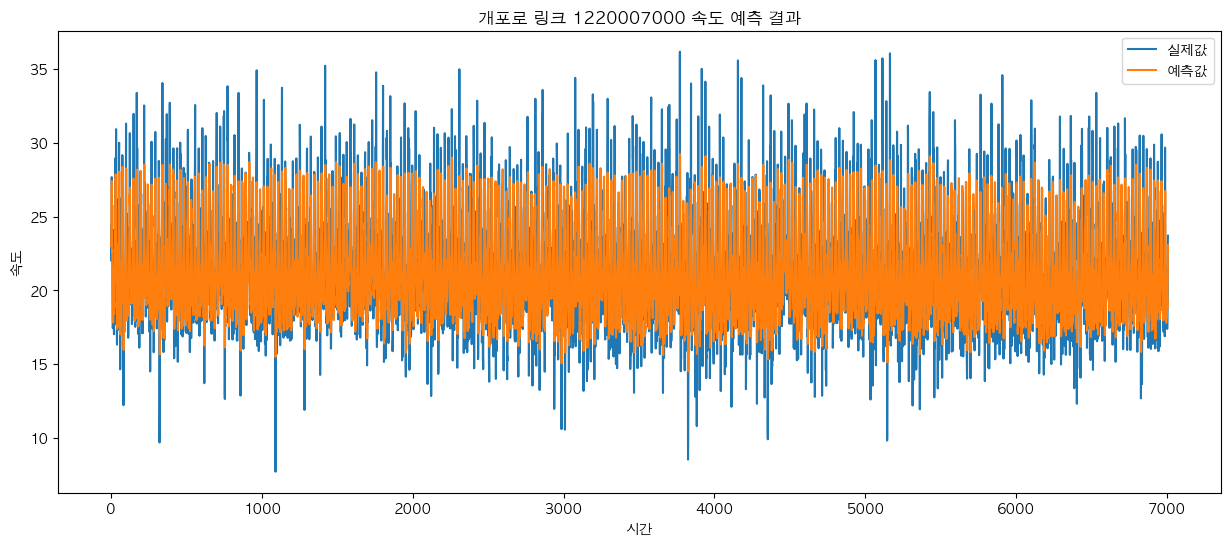

개포로의 링크 1220007000 평가 결과:
Train RMSE: 2.3074205984662464
Test RMSE: 2.5066213871338907
Train MAE: 1.732128103302993
Test MAE: 1.8628271892771207
Train R2: 0.6875704497708022
Test R2: 0.5390279642625391
Train Adjusted R2: 0.6875593035149967
Test Adjusted R2: 0.5389621675117915
--------------------------------------------------


In [8]:
results, predictions = train_lstm_model(gaepo_df, '개포로', target_col='속도')

### 모델 평가 지표 저장

In [9]:
# 결과를 DataFrame으로 변환
metrics_df = pd.DataFrame()

for link_id, data in results.items():
    metrics = pd.Series(data['metrics'], name=link_id)
    metrics_df = pd.concat([metrics_df, metrics.to_frame().T])

# 인덱스 이름을 '링크아이디'로 설정
metrics_df.index.name = '링크아이디'

# 컬럼 이름을 한글로 변경
metrics_df.columns = [
    '학습 RMSE', '테스트 RMSE',
    '학습 MAE', '테스트 MAE',
    '학습 R2', '테스트 R2',
    '학습 조정R2', '테스트 조정R2'
]

# 소수점 4자리로 반올림
metrics_df = metrics_df.round(3)

# 결과를 보기 좋게 정렬 (RMSE 기준)
metrics_df_sorted = metrics_df.sort_values('테스트 RMSE')


metrics_df_sorted.to_excel('개포로_링크별_평가지표.xlsx')